In [57]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline
# !pip install pennylane
# !pip install covalent

Quantum detection of time series anomalies
==========================================

::: {.meta}
:property=\"og:description\": Learn how to quantumly detect anomalous
behaviour in time series data with the help of Covalent.
:property=\"og:image\":
<https://pennylane.ai/qml/_images/thumbnail_tutorial_univariate_qvr.jpg>
:::

::: {.related}
tutorial\_qaoa\_intro Intro to QAOA
:::

*Authors: Jack Stephen Baker, Santosh Kumar Radha --- Posted: 7 February
2023.*

Systems producing observable characteristics which evolve with time are
almost everywhere we look. The temperature changes as day turns to
night, stock markets fluctuate and the bacteria colony living in the
coffee cup to your right, which you *promised* you would clean
yesterday, is slowly growing (seriously, clean it). In many situations,
it is important to know when these systems start behaving abnormally.
For example, if the pressure inside a nuclear fission reactor starts
violently fluctuating, you may wish to be alerted of that. The task of
identifying such temporally abnormal behaviour is known as time series
anomaly detection and is well known in machine learning circles.

In this tutorial, we take a stab at time series anomaly detection using
the *Quantum Variational Rewinding* algorithm, or QVR, proposed by
[Baker, Horowitz, Radha et. al (2022)](https://arxiv.org/abs/2210.16438)
--- a quantum machine learning algorithm for gate model quantum
computers. QVR leverages the power of unitary time evolution/devolution
operators to learn a model of *normal* behaviour for time series data.
Given a new (i.e., unseen in training) time series, the normal model
produces a value that, beyond a threshold, defines anomalous behaviour.
In this tutorial, we'll be showing you how all of this works, combining
elements from [Covalent](https://www.covalent.xyz/),
[Pennylane](https://pennylane.ai/) and [PyTorch](https://pytorch.org/).

Before getting into the technical details of the algorithm, let\'s get a
high-level overview with the help of the cartoon below.


![](../demonstrations/univariate_qvr/cartoon_pennylane.png){.align-center
width="70.0%"}

Going left-to-right, a time series is sampled at three points in time,
corresponding to different stages in the life cycle of a butterfly: a
catepillar, a chrysalis and a butterfly. This information is then
encoded into quantum states and passed to a time machine which time
devolves the states as generated by a learnt Hamiltonian operator (in
practice, there is a distribution of such operators). After the devolved
state is measured, the time series is recognized as normal if the
average measurement is smaller than a given threshold and anomalous if
the threshold is exceeded. In the first case, the time series is
considered rewindable, correctly recovering the initial condition for
the life cycle of a butterfly: eggs on a leaf. In the second case, the
output is unrecognizable.

This will all make more sense once we delve into the math a little.
Let\'s do it!


Background
==========

To begin, let's quickly recount the data that QVR handles: time series.
A general time series $\boldsymbol{y}$ can be described as a sequence of
$p$-many observations of a process/system arranged in chronological
order, where $p$ is a positive integer:

$$\boldsymbol{y} := (\boldsymbol{y}_t: t \in T), \quad T := (t_l: l \in \mathbb{Z}^{+}_{\leq p}).$$

In the simple and didactic case treated in this tutorial,
$\boldsymbol{y}$ is univariate (i.e, is a one-dimensional time series),
so bold-face for $\boldsymbol{y}$ is dropped from this point onwards.
Also, we take $y_t \in \mathbb{R}$ and $t_l \in \mathbb{R}_{>0}$.

The goal of QVR and many other (classical) machine learning algorithms
for time series anomaly detection is to determine a suitable *anomaly
score* function $a_{X}$, where $X$ is a training dataset of *normal*
time series instances $x \in X$ ($x$ is defined analogously to $y$ in
the above), from which the anomaly score function was learnt. When
passed a general time series $y$, this function produces a real number:
$a_X(y) \in \mathbb{R}$. The goal is to have $a_X(x) \approx 0$, for all
$x \in X$. Then, for an unseen time series $y$ and a threshold
$\zeta \in \mathbb{R}$, the series is said to be anomalous should
$a_X(y) > \zeta,$ and normal otherwise. We show a strategy for setting
$\zeta$ later in this tutorial.

The first step for doing all of this *quantumly* is to generate a
sequence $\mathcal{S} := (|x_{t} \rangle: t \in T)$ of $n$-qubit quantum
states corresponding to a classical time series instance in the training
set. Now, we suppose that each $|x_t \rangle$ is a quantum state evolved
to a time $t$, as generated by an *unknown embedding Hamiltonian* $H_E$.
That is, each element of $\mathcal{S}$ is defined by
$|x_t \rangle = e^{-iH_E(x_t)}|0\rangle^{\otimes n} = U(x_t)|0\rangle^{\otimes n}$
for an embedding unitary operator $U(x_t)$ implementing a quantum
feature map (see the [Pennylane embedding
templates](https://docs.pennylane.ai/en/stable/introduction/templates.html#embedding-templates)
for efficient quantum circuits for doing so). Next, we operate on each
$|x_t\rangle$ with a parameterized
$e^{-iH(\boldsymbol{\alpha}, \boldsymbol{\gamma})t}$ operator to prepare
the states

$$|x_t, \boldsymbol{\alpha}, \boldsymbol{\gamma}\rangle := e^{-iH(\boldsymbol{\alpha}, \boldsymbol{\gamma})t}|x_t\rangle,$$

where we write $e^{-iH(\boldsymbol{\alpha}, \boldsymbol{\gamma})t}$ as
an eigendecomposition

$$V_t(\boldsymbol{\alpha}, \boldsymbol{\gamma}) := W^{\dagger}(\boldsymbol{\alpha})D(\boldsymbol{\gamma}, t)W(\boldsymbol{\alpha}) = e^{-iH(\boldsymbol{\alpha}, \boldsymbol{\gamma})t}.$$

Here, the unitary matrix of eigenvectors $W(\boldsymbol{\alpha})$ is
parametrized by $\boldsymbol{\alpha}$ and the unitary diagonalization
$D(\boldsymbol{\gamma}, t)$ is parametrized by $\boldsymbol{\gamma}.$
Both can be implemented efficiently using parameterized quantum
circuits. The above equality with
$e^{-iH(\boldsymbol{\alpha}, \boldsymbol{\gamma})t}$ is a consequence of
Stone's theorem for strongly continuous one-parameter unitary groups.

We now ask the question: *What condition is required for*
$|x_t, \boldsymbol{\alpha}, \boldsymbol{\gamma} \rangle = |0 \rangle^{\otimes n}$
*for all time?* To answer this, we impose
$P(|0\rangle^{\otimes n}) = |\langle 0|^{\otimes n}|x_t, \boldsymbol{\alpha}, \boldsymbol{\gamma} \rangle|^2 = 1.$
Playing with the algebra a little, we find that the following condition
must be satisfied for all $t$:

$$\langle 0|^{\otimes n}e^{-iH(\boldsymbol{\alpha}, \boldsymbol{\gamma})t}e^{-iH_E(x_t)}|0\rangle^{\otimes n} = 1 \iff  H(\boldsymbol{\alpha}, \boldsymbol{\gamma})t = -H_E(x_t).$$

In other words, for the above to be true, the parameterized unitary
operator $V_t(\boldsymbol{\alpha}, \boldsymbol{\gamma})$ should be able
to reverse or *rewind* $|x_t\rangle$ to its initial state
$|0\rangle^{\otimes n}$ before the embedding unitary operator $U(x_t)$
was applied.

We are nearly there! Because it is reasonable to expect that a single
Hamiltonian will not be able to successfully rewind every $x \in X$ (in
fact, this is impossible to do if each $x$ is unique, which is usually
true), we consider the average effect of many Hamiltonians generated by
drawing $\boldsymbol{\gamma}$ from a normal distribution
$\mathcal{N}(\mu, \sigma)$ with mean $\mu$ and standard deviation
$\sigma$:

$$F(\boldsymbol{\phi}, x_t) := \mathop{\mathbb{E}_{\boldsymbol{\gamma} \sim \mathcal{N}(\mu, \sigma)}}\left[\langle 0|^{\otimes n} |x_t, \boldsymbol{\alpha}, \boldsymbol{\gamma}\rangle  \right], \quad \boldsymbol{\phi} = [\boldsymbol{\alpha}, \mu, \sigma].$$

The goal is for the function $F$ defined above to be as close to $1$ as
possible, for all $x \in X$ and $t \in T.$ With this in mind, we can
define the loss function to minimize as the mean square error
regularized by a penalty function $P_{\tau}(\sigma)$ with a single
hyperparameter $\tau$:

$$\mathcal{L(\boldsymbol{\phi})} = \frac{1}{2|X||T|}\sum_{x \in X} \sum_{t \in T}[1 - F(\boldsymbol{\phi}, x_t)]^2 + P_{\tau}(\sigma).$$

We will show the exact form of $P_{\tau}(\sigma)$ later. The general
purpose of the penalty function is to penalize large values of $\sigma$
(justification for this is given in the Supplement of). After
approximately finding the argument $\boldsymbol{\phi}^{\star}$ that
minimizes the loss function (found using a classical optimization
routine), we finally arrive at a definition for our anomaly score
function $a_X(y)$

$$a_X(y) = \frac{1}{|T|}\sum_{t \in T}[1 - F(\boldsymbol{\phi}^{\star}, y_t)]^2.$$

It may now be apparent that we have implemented a clustering algorithm!
That is, our model $F$ was trained such that normal time series
$x \in X$ produce $F(\boldsymbol{\phi}^{\star}, x_t)$ clustered about a
center at $1$. Given a new time series $y$, should
$F(\boldsymbol{\phi}^{\star}, y_t)$ venture far from the normal center
at $1$, we are observing anomalous behaviour!

Take the time now to have another look at the cartoon at the start of
this tutorial. Hopefully things should start making sense now.

Now with our algorithm defined, let's stitch this all together: enter
[Covalent](https://www.covalent.xyz/).


Covalent: heterogeneous workflow orchestration
==============================================

Presently, many QML algorithms are *heterogeneous* in nature. This means
that they require computational resources from both classical and
quantum computing. Covalent is a tool that can be used to manage their
interaction by sending different tasks to different computational
resources and stitching them together as a workflow. While you will be
introduced to other concepts in Covalent throughout this tutorial, we
define two key components to begin with.

1.  **Electrons**. Decorate regular Python functions with `@ct.electron`
    to desginate a *task*. These are the atoms of a computation.

2.  **Lattices**. Decorate a regular Python function with `@ct.lattice`
    to designate a *workflow*. These contain electrons stitched together
    to do something useful.

    Different electrons can be run remotely on different hardware and
    multiple computational paridigms (classical, quantum, etc.: see the
    [Covalent
    executors](https://covalent.readthedocs.io/en/stable/plugins.html)).
    In this tutorial, however, to keep things simple, tasks are run on a
    local Dask cluster, which provides (among other things)
    auto-parallelization.

![\| A schematic demonstrating the different platforms Covalent can
interact
with.](../demonstrations/univariate_qvr/covalent_platform.png){.align-center
width="70.0%"}

Now is a good time to import Covalent and launch the Covalent server!


In [58]:
import covalent as ct
import os
import time

# Set up Covalent server
os.environ["COVALENT_SERVER_IFACE_ANY"] = "1"
os.system("covalent start")
# If you run into any out-of-memory issues with Dask when running this notebook,
# Try reducing the number of workers and making a specific memory request. I.e.:
# os.system("covalent start -m "2GiB" -n 2")
# try covalent –help for more info
time.sleep(2)  # give the Dask cluster some time to launch

Generating univariate synthetic time series
===========================================

In this tutorial, we shall deal with a simple and didactic example.
Normal time series instances are chosen to be noisy low-amplitude
signals normally distributed about the origin. In our case,
$x_t \sim \mathcal{N}(0, 0.1)$. Series we deem to be anomalous are the
same but with randomly inserted spikes with random durations and
amplitudes.

Let's make a `@ct.electron` to generate each of these synthetic time
series sets. For this, we\'ll need to import Torch. We\'ll also set the
default tensor type and pick a random seed for the whole tutorial for
reproducibility.


In [59]:
import torch

# Seed Torch for reproducibility and set default tensor type
GLOBAL_SEED = 1989
torch.manual_seed(GLOBAL_SEED)
torch.set_default_tensor_type(torch.DoubleTensor)


@ct.electron
def generate_normal_time_series_set(
    p: int, num_series: int, noise_amp: float, t_init: float, t_end: float, seed: int = GLOBAL_SEED
) -> tuple:
    """Generate a normal time series data set where each of the p elements
    is drawn from a normal distribution x_t ~ N(0, noise_amp).
    """
    torch.manual_seed(seed)
    X = torch.normal(0, noise_amp, (num_series, p))
    T = torch.linspace(t_init, t_end, p)
    return X, T


@ct.electron
def generate_anomalous_time_series_set(
    p: int,
    num_series: int,
    noise_amp: float,
    spike_amp: float,
    max_duration: int,
    t_init: float,
    t_end: float,
    seed: int = GLOBAL_SEED,
) -> tuple:
    """Generate an anomalous time series data set where the p elements of each sequence are
    from a normal distribution x_t ~ N(0, noise_amp). Then,
    anomalous spikes of random amplitudes and durations are inserted.
    """
    torch.manual_seed(seed)
    Y = torch.normal(0, noise_amp, (num_series, p))
    for y in Y:
        # 5–10 spikes allowed
        spike_num = torch.randint(low=5, high=10, size=())
        durations = torch.randint(low=1, high=max_duration, size=(spike_num,))
        spike_start_idxs = torch.randperm(p - max_duration)[:spike_num]
        for start_idx, duration in zip(spike_start_idxs, durations):
            y[start_idx : start_idx + duration] += torch.normal(0.0, spike_amp, (duration,))
    T = torch.linspace(t_init, t_end, p)
    return Y, T

Let\'s do a quick sanity check and plot a couple of these series.
Despite the above function\'s `@ct.electron` decorators, these can still
be used as normal Python functions without using the Covalent server.
This is useful for quick checks like this:


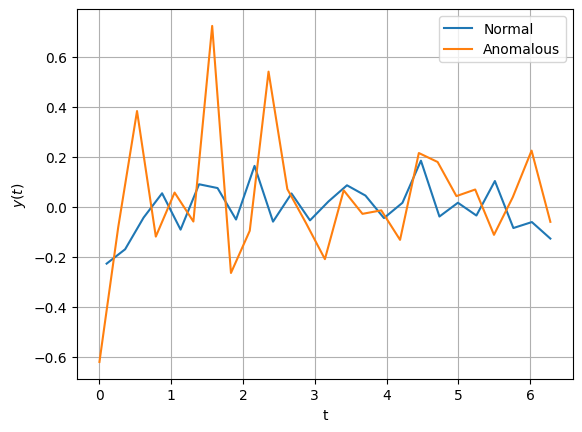

In [60]:
import matplotlib.pyplot as plt

X_norm, T_norm = generate_normal_time_series_set(25, 25, 0.1, 0.1, 2 * torch.pi)
Y_anom, T_anom = generate_anomalous_time_series_set(25, 25, 0.1, 0.4, 5, 0, 2 * torch.pi)

plt.figure()
plt.plot(T_norm, X_norm[0], label="Normal")
plt.plot(T_anom, Y_anom[1], label="Anomalous")
plt.ylabel("$y(t)$")
plt.xlabel("t")
plt.grid()
leg = plt.legend()

Taking a look at the above, the generated series are what we wanted. We
have a simple human-parsable notion of what it is for a time series to
be anomalous (big spikes). Of course, we don\'t need a complicated
algorithm to be able to detect such anomalies but this is just a
didactic example remember!

Like many machine learning algorithms, training is done in mini-batches.
Examining the form of the loss function
$\mathcal{L}(\boldsymbol{\phi})$, we can see that time series are
atomized. In other words, each term in the mean square error is for a
given $x_t$ and not measured against the entire series $x$. This allows
us to break down the training set $X$ into time-series-independent
chunks. Here's an electron to do that:


In [61]:
@ct.electron
def make_atomized_training_set(X: torch.Tensor, T: torch.Tensor) -> list:
    """Convert input time series data provided in a two-dimensional tensor format
    to atomized tuple chunks: (xt, t).
    """
    X_flat = torch.flatten(X)
    T_flat = T.repeat(X.size()[0])
    atomized = [(xt, t) for xt, t in zip(X_flat, T_flat)]
    return atomized

We now wish to pass this to a cycled `torch.utils.data.DataLoader`.
However, this object is not
[pickleable](https://docs.python.org/3/library/pickle.html#:~:text=%E2%80%9CPickling%E2%80%9D%20is%20the%20process%20whereby,back%20into%20an%20object%20hierarchy.),
which is a requirement of electrons in Covalent. We therefore use the
below helper class to create a pickleable version.


In [62]:
from collections.abc import Iterator


class DataGetter:
    """A pickleable mock-up of a Python iterator on a torch.utils.Dataloader.
    Provide a dataset X and the resulting object O will allow you to use next(O).
    """

    def __init__(self, X: torch.Tensor, batch_size: int, seed: int = GLOBAL_SEED) -> None:
        """Calls the _init_data method on intialization of a DataGetter object."""
        torch.manual_seed(seed)
        self.X = X
        self.batch_size = batch_size
        self.data = []
        self._init_data(
            iter(torch.utils.data.DataLoader(self.X, batch_size=self.batch_size, shuffle=True))
        )

    def _init_data(self, iterator: Iterator) -> None:
        """Load all of the iterator into a list."""
        x = next(iterator, None)
        while x is not None:
            self.data.append(x)
            x = next(iterator, None)

    def __next__(self) -> tuple:
        """Analogous behaviour to the native Python next() but calling the
        .pop() of the data attribute.
        """
        try:
            return self.data.pop()
        except IndexError:  # Caught when the data set runs out of elements
            self._init_data(
                iter(torch.utils.data.DataLoader(self.X, batch_size=self.batch_size, shuffle=True))
            )
            return self.data.pop()

We call an instance of the above in an electron


In [63]:
@ct.electron
def get_training_cycler(Xtr: torch.Tensor, batch_size: int, seed: int = GLOBAL_SEED) -> DataGetter:
    """Get an instance of the DataGetter class defined above, which behaves analogously to
    next(iterator) but is pickleable.
    """
    return DataGetter(Xtr, batch_size, seed)

We now have the means to create synthetic data and cycle through a
training set. Next, we need to build our loss function
$\mathcal{L}(\boldsymbol{\phi})$ from electrons with the help of
`PennyLane`.


Building the loss function
==========================

Core to building the loss function is the quantum circuit implementing
$V_t(\boldsymbol{\alpha}, \boldsymbol{\gamma}) := W^{\dagger}(\boldsymbol{\alpha})D(\boldsymbol{\gamma}, t)W(\boldsymbol{\alpha})$.
While there are existing templates in `PennyLane` for implementing
$W(\boldsymbol{\alpha})$, we use a custom circuit to implement
$D(\boldsymbol{\gamma}, t)$. Following the approach taken in (also
explained in and the appendix of), we create the electron:


In [64]:
import pennylane as qml
from itertools import combinations


@ct.electron
def D(gamma: torch.Tensor, n_qubits: int, k: int = None, get_probs: bool = False) -> None:
    """Generates an n_qubit quantum circuit according to a k-local Walsh operator
    expansion. Here, k-local means that 1 <= k <= n of the n qubits can interact.
    See <https://doi.org/10.1088/1367-2630/16/3/033040> for more
    details. Optionally return probabilities of bit strings.
    """
    if k is None:
        k = n_qubits
    cnt = 0
    for i in range(1, k + 1):
        for comb in combinations(range(n_qubits), i):
            if len(comb) == 1:
                qml.RZ(gamma[cnt], wires=[comb[0]])
                cnt += 1
            elif len(comb) > 1:
                cnots = [comb[i : i + 2] for i in range(len(comb) - 1)]
                for j in cnots:
                    qml.CNOT(wires=j)
                qml.RZ(gamma[cnt], wires=[comb[-1]])
                cnt += 1
                for j in cnots[::-1]:
                    qml.CNOT(wires=j)
    if get_probs:
        return qml.probs(wires=range(n_qubits))

While the above may seem a little complicated, since we only use a
single qubit in this tutorial, the resulting circuit is merely a single
$R_z(\theta)$ gate.


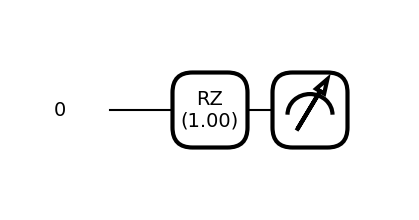

In [65]:
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits, shots=None)
D_one_qubit = qml.qnode(dev)(D)
_ = qml.draw_mpl(D_one_qubit, decimals=2)(torch.tensor([1, 0]), 1, 1, True)

You may find the general function for $D$\` useful in case you want to
experiment with more qubits and your own (possibly multi-dimensional)
data after this tutorial.

Next, we define a circuit to calculate the probability of certain bit
strings being measured in the computational basis. In our simple
example, we work only with one qubit and use the `default.qubit` local
quantum circuit simulator.


In [66]:
@ct.electron
@qml.qnode(dev, interface="torch", diff_method="backprop")
def get_probs(
    xt: torch.Tensor,
    t: float,
    alpha: torch.Tensor,
    gamma: torch.Tensor,
    k: int,
    U: callable,
    W: callable,
    D: callable,
    n_qubits: int,
) -> torch.Tensor:
    """Measure the probabilities for measuring each bitstring after applying a
    circuit of the form W†DWU to the |0⟩^(⊗n) state. This
    function is defined for individual sequence elements xt.
    """
    U(xt, wires=range(n_qubits))
    W(alpha, wires=range(n_qubits))
    D(gamma * t, n_qubits, k)
    qml.adjoint(W)(alpha, wires=range(n_qubits))
    return qml.probs(range(n_qubits))

To take the projector $|0\rangle^{\otimes n} \langle 0 |^{\otimes n}$,
we consider only the probability of measuring the bit string of all
zeroes, which is the 0th element of the probabilities (bit strings are
returned in lexicographic order).


In [67]:
@ct.electron
def get_callable_projector_func(
    k: int, U: callable, W: callable, D: callable, n_qubits: int, probs_func: callable
) -> callable:
    """Using get_probs() above, take only the probability of measuring the
    bitstring of all zeroes (i.e, take the projector
    |0⟩^(⊗n)⟨0|^(⊗n)) on the time devolved state.
    """
    callable_proj = lambda xt, t, alpha, gamma: probs_func(
        xt, t, alpha, gamma, k, U, W, D, n_qubits
    )[0]
    return callable_proj

We now have the necessary ingredients to build
$F(\boldsymbol{\phi}, x_t)$.


In [68]:
@ct.electron
def F(
    callable_proj: callable,
    xt: torch.Tensor,
    t: float,
    alpha: torch.Tensor,
    mu: torch.Tensor,
    sigma: torch.Tensor,
    gamma_length: int,
    n_samples: int,
) -> torch.Tensor:
    """Take the classical expecation value of of the projector on zero sampling
    the parameters of D from normal distributions. The expecation value is estimated
    with an average over n_samples.
    """
    # length of gamma should not exceed 2^n - 1
    gammas = sigma.abs() * torch.randn((n_samples, gamma_length)) + mu
    expectation = torch.empty(n_samples)
    for i, gamma in enumerate(gammas):
        expectation[i] = callable_proj(xt, t, alpha, gamma)
    return expectation.mean()

We now return to the matter of the penalty function $P_{\tau}$. We
choose

$$P_{\tau}(\sigma) := \frac{1}{\pi} \arctan(2 \pi \tau |\sigma|).$$

As an electron, we have


In [69]:
@ct.electron
def callable_arctan_penalty(tau: float) -> callable:
    """Create a callable arctan function with a single hyperparameter
    tau to penalize large entries of sigma.
    """
    prefac = 1 / (torch.pi)
    callable_pen = lambda sigma: prefac * torch.arctan(2 * torch.pi * tau * sigma.abs()).mean()
    return callable_pen

The above is a sigmoidal function chosen because it comes with the
useful property of being bounded. The prefactor of $1/\pi$ is chosen
such that the final loss $\mathcal{L}(\boldsymbol{\phi})$ is defined in
the range (0, 1), as defined in the below electron.


In [70]:
@ct.electron
def get_loss(
    callable_proj: callable,
    batch: torch.Tensor,
    alpha: torch.Tensor,
    mu: torch.Tensor,
    sigma: torch.Tensor,
    gamma_length: int,
    n_samples: int,
    callable_penalty: callable,
) -> torch.Tensor:
    """Evaluate the loss function ℒ, defined in the background section
    for a certain set of parameters.
    """
    X_batch, T_batch = batch
    loss = torch.empty(X_batch.size()[0])
    for i in range(X_batch.size()[0]):
        # unsqueeze required for tensor to have the correct dimension for PennyLane templates
        loss[i] = (
            1
            - F(
                callable_proj,
                X_batch[i].unsqueeze(0),
                T_batch[i].unsqueeze(0),
                alpha,
                mu,
                sigma,
                gamma_length,
                n_samples,
            )
        ).square()
    return 0.5 * loss.mean() + callable_penalty(sigma)

Training the normal model
=========================

Now equipped with a loss function, we need to minimize it with a
classical optimization routine. To start this optimization, however, we
need some initial parameters. We can generate them with the below
electron.


In [71]:
@ct.electron
def get_initial_parameters(
    W: callable, W_layers: int, n_qubits: int, seed: int = GLOBAL_SEED
) -> dict:
    """Randomly generate initial parameters. We need initial parameters for the
    variational circuit ansatz implementing W(alpha) and the standard deviation
    and mean (sigma and mu) for the normal distribution we sample gamma from.
    """
    torch.manual_seed(seed)
    init_alpha = torch.rand(W.shape(W_layers, n_qubits))
    init_mu = torch.rand(1)
    # Best to start sigma small and expand if needed
    init_sigma = torch.rand(1)
    init_params = {
        "alpha": (2 * torch.pi * init_alpha).clone().detach().requires_grad_(True),
        "mu": (2 * torch.pi * init_mu).clone().detach().requires_grad_(True),
        "sigma": (0.1 * init_sigma + 0.05).clone().detach().requires_grad_(True),
    }
    return init_params

Using the `PyTorch` interface to `PennyLane`, we define our final
electron before running the training workflow.


In [72]:
@ct.electron
def train_model_gradients(
    lr: float,
    init_params: dict,
    pytorch_optimizer: callable,
    cycler: DataGetter,
    n_samples: int,
    callable_penalty: callable,
    batch_iterations: int,
    callable_proj: callable,
    gamma_length: int,
    seed=GLOBAL_SEED,
    print_intermediate=False,
) -> dict:
    """Train the QVR model (minimize the loss function) with respect to the
    variational parameters using gradient-based training. You need to pass a
    PyTorch optimizer and a learning rate (lr).
    """
    torch.manual_seed(seed)
    opt = pytorch_optimizer(init_params.values(), lr=lr)
    alpha = init_params["alpha"]
    mu = init_params["mu"]
    sigma = init_params["sigma"]

    def closure():
        opt.zero_grad()
        loss = get_loss(
            callable_proj, next(cycler), alpha, mu, sigma, gamma_length, n_samples, callable_penalty
        )
        loss.backward()
        return loss

    loss_history = []
    for i in range(batch_iterations):
        loss = opt.step(closure)
        loss_history.append(loss.item())
        if batch_iterations % 10 == 0 and print_intermediate:
            print(f"Iteration number {i}\n Current loss {loss.item()}\n")

    results_dict = {
        "opt_params": {
            "alpha": opt.param_groups[0]["params"][0],
            "mu": opt.param_groups[0]["params"][1],
            "sigma": opt.param_groups[0]["params"][2],
        },
        "loss_history": loss_history,
    }
    return results_dict

Now, enter our first `@ct.lattice`. This combines the above electrons,
eventually returning the optimal parameters $\boldsymbol{\phi}^{\star}$
and the loss with batch iterations.


In [73]:
@ct.lattice
def training_workflow(
    U: callable,
    W: callable,
    D: callable,
    n_qubits: int,
    k: int,
    probs_func: callable,
    W_layers: int,
    gamma_length: int,
    n_samples: int,
    p: int,
    num_series: int,
    noise_amp: float,
    t_init: float,
    t_end: float,
    batch_size: int,
    tau: float,
    pytorch_optimizer: callable,
    lr: float,
    batch_iterations: int,
):
    """
    Combine all of the previously defined electrons to do an entire training workflow,
    including (1) generating synthetic data, (2) packaging it into training cyclers
    (3) preparing the quantum functions and (4) optimizing the loss function with
    gradient based optimization. You can find definitions for all of the arguments
    by looking at the electrons and text cells above.
    """

    X, T = generate_normal_time_series_set(p, num_series, noise_amp, t_init, t_end)
    Xtr = make_atomized_training_set(X, T)
    cycler = get_training_cycler(Xtr, batch_size)
    init_params = get_initial_parameters(W, W_layers, n_qubits)
    callable_penalty = callable_arctan_penalty(tau)
    callable_proj = get_callable_projector_func(k, U, W, D, n_qubits, probs_func)
    results_dict = train_model_gradients(
        lr,
        init_params,
        pytorch_optimizer,
        cycler,
        n_samples,
        callable_penalty,
        batch_iterations,
        callable_proj,
        gamma_length,
        print_intermediate=False,
    )
    return results_dict

Before running this workflow, we define all of the input parameters.


In [74]:
general_options = {
    "U": qml.AngleEmbedding,
    "W": qml.StronglyEntanglingLayers,
    "D": D,
    "n_qubits": 1,
    "probs_func": get_probs,
    "gamma_length": 1,
    "n_samples": 10,
    "p": 25,
    "num_series": 25,
    "noise_amp": 0.1,
    "t_init": 0.1,
    "t_end": 2 * torch.pi,
    "k": 1,
}

training_options = {
    "batch_size": 10,
    "tau": 5,
    "pytorch_optimizer": torch.optim.Adam,
    "lr": 0.01,
    "batch_iterations": 100,
    "W_layers": 2,
}

training_options.update(general_options)

We can now dispatch the lattice to the Covalent server.


In [75]:
tr_dispatch_id = ct.dispatch(training_workflow)(**training_options)

If you are running the notebook version of this tutorial, if you
navigate to <http://localhost:48008/> you can view the workflow on the
Covalent GUI. It will look like the screenshot below, showing nicely how
all of the electrons defined above interact with each other in the
workflow. You can also track the progress of the calculation here.

![A screenshot of the Covalent GUI for the training
workflow.](../demonstrations/univariate_qvr/covalent_tutorial_screenshot.png){.align-center
width="85.0%"}


We now pull the results back from the Covalent server:


In [76]:
ct_tr_results = ct.get_result(dispatch_id=tr_dispatch_id, wait=True)
results_dict = ct_tr_results.result

and take a look at the training loss history:


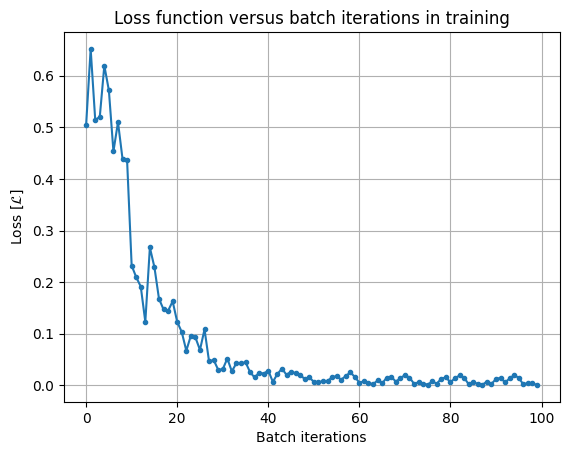

In [77]:
plt.figure()
plt.plot(results_dict["loss_history"], ".-")
plt.ylabel("Loss [$\mathcal{L}$]")
plt.xlabel("Batch iterations")
plt.title("Loss function versus batch iterations in training")
plt.grid()

Tuning the threshold $\zeta$
============================

When we have access to labelled anomalous series (as we do in our toy
problem here, often not the case in reality), we can tune the threshold
$\zeta$ to maximize some success metric. We choose to maximize the
accuracy score as defined using the three electrons below.


In [78]:
@ct.electron
def get_preds_given_threshold(zeta: float, scores: torch.Tensor) -> torch.Tensor:
    """For a given threshold, get the predicted labels (1 or -1), given the anomaly scores."""
    return torch.tensor([-1 if score > zeta else 1 for score in scores])


@ct.electron
def get_truth_labels(
    normal_series_set: torch.Tensor, anomalous_series_set: torch.Tensor
) -> torch.Tensor:
    """Get a 1D tensor containing the truth values (1 or -1) for a given set of
    time series.
    """
    norm = torch.ones(normal_series_set.size()[0])
    anom = -torch.ones(anomalous_series_set.size()[0])
    return torch.cat([norm, anom])


@ct.electron
def get_accuracy_score(pred: torch.Tensor, truth: torch.Tensor) -> torch.Tensor:
    """Given the predictions and truth values, return a number between 0 and 1
    indicating the accuracy of predictions.
    """
    return torch.sum(pred == truth) / truth.size()[0]

Then, knowing the anomaly scores $a_X(y)$ for a validation data set, we
can scan through various values of $\zeta$ on a fine 1D grid and
calcuate the accuracy score. Our goal is to pick the $\zeta$ with the
largest accuracy score.


In [79]:
@ct.electron
def threshold_scan_acc_score(
    scores: torch.Tensor, truth_labels: torch.Tensor, zeta_min: float, zeta_max: float, steps: int
) -> torch.Tensor:
    """Given the anomaly scores and truth values,
    scan over a range of thresholds = [zeta_min, zeta_max] with a
    fixed number of steps, calculating the accuracy score at each point.
    """
    accs = torch.empty(steps)
    for i, zeta in enumerate(torch.linspace(zeta_min, zeta_max, steps)):
        preds = get_preds_given_threshold(zeta, scores)
        accs[i] = get_accuracy_score(preds, truth_labels)
    return accs


@ct.electron
def get_anomaly_score(
    callable_proj: callable,
    y: torch.Tensor,
    T: torch.Tensor,
    alpha_star: torch.Tensor,
    mu_star: torch.Tensor,
    sigma_star: torch.Tensor,
    gamma_length: int,
    n_samples: int,
    get_time_resolved: bool = False,
):
    """Get the anomaly score for an input time series y. We need to pass the
    optimal parameters (arguments with suffix _star). Optionally return the
    time-resolved score (the anomaly score contribution at a given t).
    """
    scores = torch.empty(T.size()[0])
    for i in range(T.size()[0]):
        scores[i] = (
            1
            - F(
                callable_proj,
                y[i].unsqueeze(0),
                T[i].unsqueeze(0),
                alpha_star,
                mu_star,
                sigma_star,
                gamma_length,
                n_samples,
            )
        ).square()
    if get_time_resolved:
        return scores, scores.mean()
    else:
        return scores.mean()


@ct.electron
def get_norm_and_anom_scores(
    X_norm: torch.Tensor,
    X_anom: torch.Tensor,
    T: torch.Tensor,
    callable_proj: callable,
    model_params: dict,
    gamma_length: int,
    n_samples: int,
) -> torch.Tensor:
    """Get the anomaly scores assigned to input normal and anomalous time series instances.
    model_params is a dictionary containing the optimal model parameters.
    """
    alpha = model_params["alpha"]
    mu = model_params["mu"]
    sigma = model_params["sigma"]
    norm_scores = torch.tensor(
        [
            get_anomaly_score(callable_proj, xt, T, alpha, mu, sigma, gamma_length, n_samples)
            for xt in X_norm
        ]
    )
    anom_scores = torch.tensor(
        [
            get_anomaly_score(callable_proj, xt, T, alpha, mu, sigma, gamma_length, n_samples)
            for xt in X_anom
        ]
    )
    return torch.cat([norm_scores, anom_scores])

We now create our second `@ct.lattice`. We are to test the optimal model
against two random models. If our model is trainable, we should see that
the trained model is better.


In [80]:
@ct.lattice
def threshold_tuning_workflow(
    opt_params: dict,
    gamma_length: int,
    n_samples: int,
    probs_func: callable,
    zeta_min: float,
    zeta_max: float,
    steps: int,
    p: int,
    num_series: int,
    noise_amp: float,
    spike_amp: float,
    max_duration: int,
    t_init: float,
    t_end: float,
    k: int,
    U: callable,
    W: callable,
    D: callable,
    n_qubits: int,
    random_model_seeds: torch.Tensor,
    W_layers: int,
) -> tuple:
    """A workflow for tuning the threshold value zeta, in order to maximize the accuracy score
    for a validation data set. Results are tested against random models at their optimal zetas.
    """
    # Generate datasets
    X_val_norm, T = generate_normal_time_series_set(p, num_series, noise_amp, t_init, t_end)
    X_val_anom, T = generate_anomalous_time_series_set(
        p, num_series, noise_amp, spike_amp, max_duration, t_init, t_end
    )
    truth_labels = get_truth_labels(X_val_norm, X_val_anom)

    # Initialize quantum functions
    callable_proj = get_callable_projector_func(k, U, W, D, n_qubits, probs_func)

    accs_list = []
    scores_list = []
    # Evaluate optimal model
    scores = get_norm_and_anom_scores(
        X_val_norm, X_val_anom, T, callable_proj, opt_params, gamma_length, n_samples
    )
    accs_opt = threshold_scan_acc_score(scores, truth_labels, zeta_min, zeta_max, steps)
    accs_list.append(accs_opt)
    scores_list.append(scores)

    # Evaluate random models
    for seed in random_model_seeds:
        rand_params = get_initial_parameters(W, W_layers, n_qubits, seed)
        scores = get_norm_and_anom_scores(
            X_val_norm, X_val_anom, T, callable_proj, rand_params, gamma_length, n_samples
        )
        accs_list.append(threshold_scan_acc_score(scores, truth_labels, zeta_min, zeta_max, steps))
        scores_list.append(scores)
    return accs_list, scores_list

We now set the input parameters.


In [81]:
threshold_tuning_options = {
    "spike_amp": 0.4,
    "max_duration": 5,
    "zeta_min": 0,
    "zeta_max": 1,
    "steps": 100000,
    "random_model_seeds": [0, 1],
    "W_layers": 2,
    "opt_params": results_dict["opt_params"],
}

threshold_tuning_options.update(general_options)

As before, we dispatch the lattice to the `Covalent` server.


In [82]:
val_dispatch_id = ct.dispatch(threshold_tuning_workflow)(**threshold_tuning_options)
ct_val_results = ct.get_result(dispatch_id=val_dispatch_id, wait=True)
accs_list, scores_list = ct_val_results.result

Now, we can plot the results:


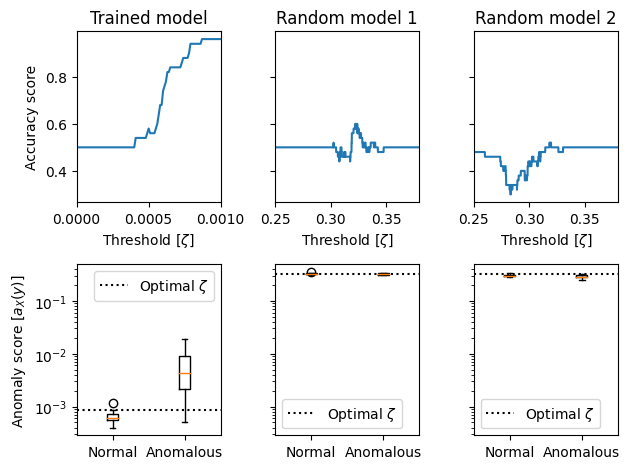

In [83]:
zeta_xlims = [(0, 0.001), (0.25, 0.38), (0.25, 0.38)]
titles = ["Trained model", "Random model 1", "Random model 2"]
zetas = torch.linspace(
    threshold_tuning_options["zeta_min"],
    threshold_tuning_options["zeta_max"],
    threshold_tuning_options["steps"],
)
fig, axs = plt.subplots(ncols=3, nrows=2, sharey="row")
for i in range(3):
    axs[0, i].plot(zetas, accs_list[i])
    axs[0, i].set_xlim(zeta_xlims[i])
    axs[0, i].set_xlabel("Threshold [$\zeta$]")
    axs[0, i].set_title(titles[i])
    axs[1, i].boxplot(
        [
            scores_list[i][0 : general_options["num_series"]],
            scores_list[i][general_options["num_series"] : -1],
        ],
        labels=["Normal", "Anomalous"],
    )
    axs[1, i].set_yscale("log")
    axs[1, i].axhline(
        zetas[torch.argmax(accs_list[i])], color="k", linestyle=":", label="Optimal $\zeta$"
    )
    axs[1, i].legend()
axs[0, 0].set_ylabel("Accuracy score")
axs[1, 0].set_ylabel("Anomaly score [$a_X(y)$]")
fig.tight_layout()

Parsing the above, we can see that the optimal model achieves high
accuracy when the threshold is tuned using the validation data. On the
other hand, the random models return mostly random results (sometimes
even worse than random guesses), regardless of how we set the threshold.


Testing the model
=================

Now with optimal thresholds for our optimized and random models, we can
perform testing. We already have all of the electrons to do this, so we
create the `@ct.lattice`


In [84]:
@ct.lattice
def testing_workflow(
    opt_params: dict,
    gamma_length: int,
    n_samples: int,
    probs_func: callable,
    best_zetas: list,
    p: int,
    num_series: int,
    noise_amp: float,
    spike_amp: float,
    max_duration: int,
    t_init: float,
    t_end: float,
    k: int,
    U: callable,
    W: callable,
    D: callable,
    n_qubits: int,
    random_model_seeds: torch.Tensor,
    W_layers: int,
) -> list:
    """A workflow for calculating anomaly scores for a set of testing time series
    given an optimal model and set of random models. We use the optimal zetas found in threshold tuning.
    """
    # Generate time series
    X_val_norm, T = generate_normal_time_series_set(p, num_series, noise_amp, t_init, t_end)
    X_val_anom, T = generate_anomalous_time_series_set(
        p, num_series, noise_amp, spike_amp, max_duration, t_init, t_end
    )
    truth_labels = get_truth_labels(X_val_norm, X_val_anom)

    # Prepare quantum functions
    callable_proj = get_callable_projector_func(k, U, W, D, n_qubits, probs_func)

    accs_list = []
    # Evaluate optimal model
    scores = get_norm_and_anom_scores(
        X_val_norm, X_val_anom, T, callable_proj, opt_params, gamma_length, n_samples
    )
    preds = get_preds_given_threshold(best_zetas[0], scores)
    accs_list.append(get_accuracy_score(preds, truth_labels))
    # Evaluate random models
    for zeta, seed in zip(best_zetas[1:], random_model_seeds):
        rand_params = get_initial_parameters(W, W_layers, n_qubits, seed)
        scores = get_norm_and_anom_scores(
            X_val_norm, X_val_anom, T, callable_proj, rand_params, gamma_length, n_samples
        )
        preds = get_preds_given_threshold(zeta, scores)
        accs_list.append(get_accuracy_score(preds, truth_labels))
    return accs_list

We dispatch it to the Covalent server with the appropriate parameters.


In [85]:
testing_options = {
    "spike_amp": 0.4,
    "max_duration": 5,
    "best_zetas": [zetas[torch.argmax(accs)] for accs in accs_list],
    "random_model_seeds": [0, 1],
    "W_layers": 2,
    "opt_params": results_dict["opt_params"],
}

testing_options.update(general_options)

test_dispatch_id = ct.dispatch(testing_workflow)(**testing_options)
ct_test_results = ct.get_result(dispatch_id=test_dispatch_id, wait=True)
accs_list = ct_test_results.result

Finally, we plot the results below.


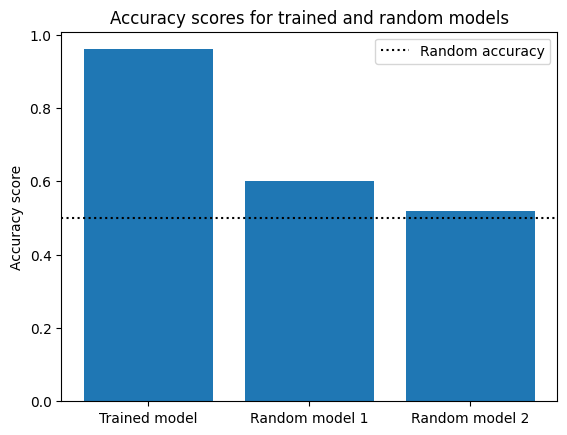

In [86]:
plt.figure()
plt.bar([1, 2, 3], accs_list)
plt.axhline(0.5, color="k", linestyle=":", label="Random accuracy")
plt.xticks([1, 2, 3], ["Trained model", "Random model 1", "Random model 2"])
plt.ylabel("Accuracy score")
plt.title("Accuracy scores for trained and random models")
leg = plt.legend()

As can be seen, once more, the trained model is far more accurate than
the random models. Awesome! Now that we\'re done with the calculations
in this tutorial, we just need to remember to shut down the Covalent
server


In [87]:
# Shut down the covalent server
stop = os.system("covalent stop")

Conclusions
===========

We\'ve now reached the end of this tutorial! Quickly recounting what we
have learnt, we:

1.  Learnt the background of how to detect anomalous time series
    instances, *quantumly*,
2.  Learnt how to build the code to achieve this using PennyLane and
    PyTorch, and,
3.  Learnt the basics of Covalent: a workflow orchestration tool for
    heterogeneous computation

If you want to learn more about QVR, you should consult the paper where
we generalize the math a little and test the algorithm on less trivial
time series data than was dealt with in this tutorial. We also ran some
experiments on real quantum computers, enhancing our results using error
mitigation techniques. If you want to play some more with Covalent,
check us out on [GitHub](https://github.com/AgnostiqHQ/covalent/) and/or
engage with other tutorials in our
[documentation](https://covalent.readthedocs.io/en/stable/).


References
==========

About the authors \-\-\-\-\-\-\-\-\-\-\-\-\-\-\--.. include::
../\_static/authors/jack\_stephen\_baker.txt .. include::
../\_static/authors/santosh\_kumar\_radha.txt
